## Analysis on occluded datasets

In [6]:
import unicom
import torch

from torch.utils.data import DataLoader
from torchvision.datasets import DTD
from tqdm import tqdm
from torch.nn.functional import normalize
import matplotlib.pyplot as plt

from dataset import Inshop_Dataset

In [7]:
model, preprocess = unicom.load(name="ViT-B/16", path='/home/haeji/unicom/24.pt')
model = model.cuda()
model.eval()

Loaded model from /home/haeji/unicom/24.pt!


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (drop_path): Identity()
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): ReLU6()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768

In [8]:
test_original = Inshop_Dataset("data", "query", preprocess, None)

In [9]:
test_black = Inshop_Dataset("data", "query", preprocess, "black_mask")

In [10]:
def get_features(dataset):
    all_features = []
    with torch.no_grad():
        for images, _ in tqdm(DataLoader(dataset, batch_size=16, num_workers=4, shuffle=True)):
            features = model(images.cuda())
            all_features.append(features)
    return torch.cat(all_features)

In [ ]:
def get_images(dataset):
    all_images = []
    with torch.no_grad():
        for images, _ in tqdm(DataLoader(dataset, batch_size=16, num_workers=4, shuffle=False)):
            all_images.append(images)
    return torch.cat(all_images)

In [3]:
images = get_images(test_black)

NameError: name 'get_images' is not defined

In [6]:
features = get_features(test_black)

  0%|          | 0/889 [00:00<?, ?it/s]/home/haeji/miniconda3/envs/unicom/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 889/889 [01:15<00:00, 11.72it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


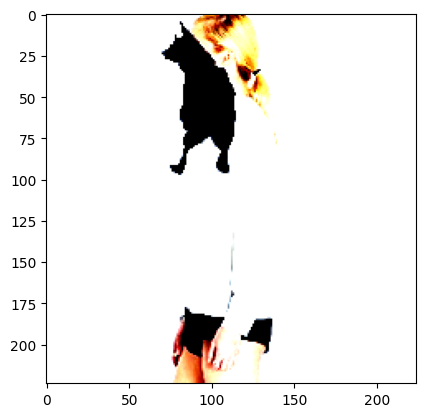

In [17]:
plt.imshow(images[0].permute(1,2,0))

In [13]:
original_images = get_images(test_original)

100%|██████████| 889/889 [00:13<00:00, 67.74it/s]


In [7]:
original_features = get_features(test_original)

100%|██████████| 889/889 [01:12<00:00, 12.31it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


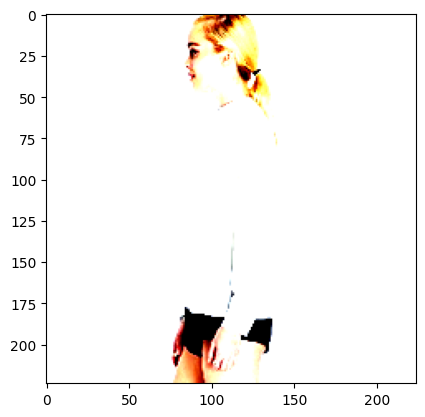

In [18]:
plt.imshow(original_images[0].permute(1,2,0))

In [2]:
images.shape

NameError: name 'images' is not defined

In [19]:
# image distribution
import seaborn as sns

for c in range(3):
    sns.distplot(images[:,:,c])
sns.distplot(images)

/tmp/ipykernel_90193/1399602144.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(images)


: 

shape of all_features: (28436, 768)


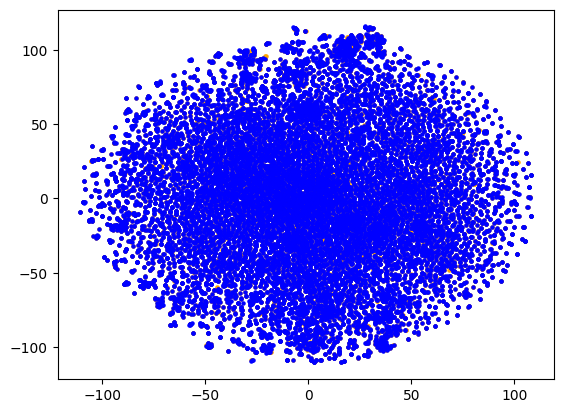

In [8]:
from sklearn.manifold import TSNE
from matplotlib.pyplot import scatter

all_features = torch.concat([original_features, features]).cpu().numpy()
print("shape of all_features:", all_features.shape)

tsne = TSNE(perplexity=40)
X_low = tsne.fit_transform(all_features)
num_features = len(original_features)

scatter(X_low[:num_features,0], X_low[:num_features,1], c='orange', s=5)
scatter(X_low[num_features:,0], X_low[num_features:,1], c='blue', s=5)


## Looking for Critical Part
Look for some crucial part of the image that affects model's retrieval performance a lot.

Give the model various set of occluded images, using one single image (at a time).

In [ ]:
database = Inshop_Dataset('data', 'gallery', preprocess)
